In [1]:
from EMAN2 import *
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


/home/muyuanc/mambaforge/envs/eman2/lib/python3.12/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/muyuanc/mambaforge/envs/eman2/lib/python3.12/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/muyuanc/mambaforge/envs/eman2/lib/python3.12/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/muyuanc/mambaforge/envs/eman2/lib/python3.12/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]='0' 
import jax
import jax.numpy as jnp
jax.devices()

[CudaDevice(id=0)]

In [3]:
from flax import nnx
import flax.linen as nn
import optax
from jax import jit

In [4]:
fname="sim/ptcls_02.hdf"
nptcl=EMUtil.get_image_count(fname)
projs=[]
hdrs=[]
e=EMData(fname, 0, True)
rawbox=e["nx"]
for j in range(0,nptcl,1000):
    print(f"\r {j}/{nptcl} ",end="")
    sys.stdout.flush()
    el=EMData.read_images(fname,range(j,min(j+1000,nptcl)))
    print(f"R     ",end="")
    sys.stdout.flush()
    for e in el:
        hdrs.append(e.get_attr_dict())
        projs.append(e.numpy().copy())
print(f"{nptcl}/{nptcl}")
projs=np.array(projs, dtype=np.float32)
clsid=np.array([h["class_id"] for h in hdrs])

 5000/5464    R     R     R     R     R     5464/5464


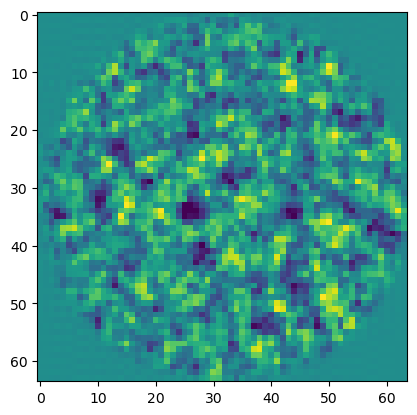

In [5]:
plt.imshow(projs[123])

In [6]:
rawbox=projs.shape[-1]
##################
## index for rotation
ind_xy=np.indices((rawbox, rawbox))-rawbox//2
# ind_xy=np.fft.ifftshift(ind_xy)
# ind_xy=ind_xy[:,:,:rawbox//2+1]
print(ind_xy.shape)
ind_xy=ind_xy.transpose((1,2,0)).reshape((-1,2))
ind_xy=ind_xy.astype(np.float32)

##################
## index for interpolation
ind_interp=np.indices((2,2))
ind_interp=ind_interp.transpose((1,2,0)).reshape(-1,2)

(2, 64, 64)


2024-10-14 14:28:54.302033: W external/xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version 12.6.77. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
/home/muyuanc/mambaforge/envs/eman2/lib/python3.12/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/muyuanc/mambaforge/envs/eman2/lib/python3.12/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


(2, 64, 64)


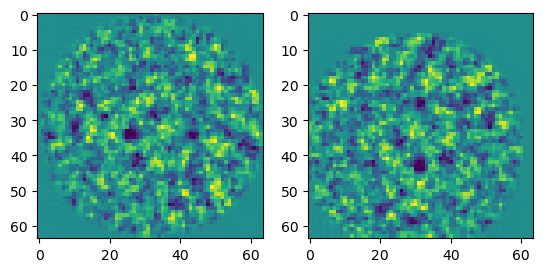

In [7]:
def make_matrix(a):
    matrix=jnp.array([
    [jnp.cos(a), -jnp.sin(a)],
    [jnp.sin(a),  jnp.cos(a)],
    ])
    matrix=jnp.transpose(matrix)
    return matrix
    
def rotate_translate_image(img, angs):
    matrix=make_matrix(angs[:,0])
    
    ind_rot=jnp.matmul(matrix, ind_xy.T)
    ind_rot=jnp.transpose(ind_rot, (0,2,1))
    ind_rot=ind_rot+angs[:,None,1:3]
    
    ind_rot+=rawbox//2
    
    
    ix=jnp.floor(ind_rot).astype(int)
    
    ir=ind_rot-jnp.floor(ind_rot)
    ir=[ir, 1-ir]
    
    
    rots=[]
    for i0 in ind_interp:
        w=ir[0]*i0+ir[1]*(1-i0)
        w=jnp.prod(w, axis=2)
    
        ix0=ix+i0
        ix1=jnp.clip(ix0, 0, rawbox-1)
        rt=img[tuple(jnp.moveaxis(ix1, -1, 0))]*w
        
        edge=jnp.prod(ix0==ix1, axis=-1).astype(float)
        rt=rt*edge
        
        rots.append(rt)

    rots=jnp.array(rots)
    img_rot=jnp.sum(rots, axis=0)
    img_rot=img_rot.reshape((img_rot.shape[0], rawbox, -1))
    return img_rot

ang=np.array([[0,0,0],[np.deg2rad(90),3,5]], dtype=np.float32)
imgrot=rotate_translate_image(projs[123],ang)
print(imgrot.shape)
plt.subplot(1,2,1)
plt.imshow(imgrot[0])
plt.subplot(1,2,2)
plt.imshow(imgrot[1])

(2, 64, 64)


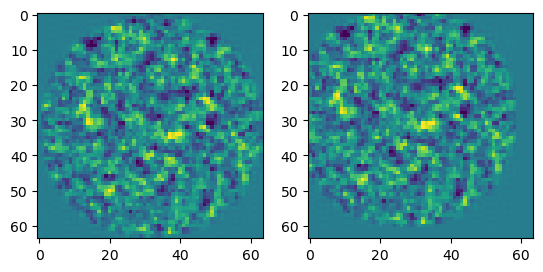

In [8]:

ang=np.array([[0,0,0],[0,3,5]], dtype=np.float32)
imgrot=rotate_translate_image(projs[1234],ang)

# imgrot=[projs[0][8:,8:], projs[0][3:-5, 8:]]
# imgrot=[projs[0][8:,8:], projs[0][2:-6, 8:]]
imgrot=np.array(imgrot)
print(imgrot.shape)
plt.subplot(1,2,1)
plt.imshow(imgrot[0])
plt.subplot(1,2,2)
plt.imshow(imgrot[1])

In [9]:

rng_key=jax.random.key(0)
rng_init, rng_drop = jax.random.split(key=rng_key, num=2)
rng_drop=jax.random.fold_in(rng_drop,0)

In [10]:
class Encoder(nn.Module):
    @nn.compact
    def __call__(self, x, training=False):
        x = nn.Conv(64, (5,5))(x)
        x = nn.relu(x)
        # x = nn.Dropout(0.1, deterministic=not training)(x)
        x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2))
        
        x = nn.Conv(128, (5,5))(x)
        x = nn.relu(x)
        # x = nn.Dropout(0.1, deterministic=not training)(x)
        x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2))
        
        x = nn.Conv(256, (5,5))(x)
        x = nn.relu(x)
        # x = nn.Dropout(0.1, deterministic=not training)(x)

        x = jnp.max(x, axis=(1,2))
        
        x = nn.Dense(64)(x)
        x = nn.Dropout(0.1, deterministic=not training)(x)
        # x = nn.BatchNorm(use_running_average=not training)(x)
        x = nn.Dense(8)(x)
        return x


encode_model = Encoder()
batch = projs[:2,:,:,None]
enc_var = encode_model.init(rng_init, batch)
mid = encode_model.apply(enc_var, batch, training=True, rngs={"dropout": rng_drop})
print(mid.shape)


(2, 8)


In [11]:
class Decoder(nn.Module):
    @nn.compact
    def __call__(self, x, training=False):
        
        x = nn.Dense(64)(x)
        # x = nn.Dropout(0.1, deterministic=not training)(x)
        x = nn.Dense(256)(x)
        # x = nn.Dropout(0.1, deterministic=not training)(x)

        x = x.reshape((-1,8,8,4))
        
        x = nn.ConvTranspose(256, (5,5), strides=(2,2))(x)
        x = nn.relu(x)
        # x = nn.Dropout(0.1, deterministic=not training)(x)
        
        x = nn.ConvTranspose(128, (5,5), strides=(2,2))(x)
        x = nn.relu(x)
        # x = nn.Dropout(0.1, deterministic=not training)(x)
        
        x = nn.ConvTranspose(64, (5,5), strides=(2,2))(x)
        x = nn.relu(x)
        x = nn.Dropout(0.1, deterministic=not training)(x)
        # x = nn.BatchNorm(use_running_average=not training)(x)
        
        x = nn.Conv(1, (5,5))(x)
        # x=x/jnp.std(x, axis=(1,2,3))
        # x = nn.Dense(8)(x)
        return x


decode_model = Decoder()
dec_var = decode_model.init(rng_init, mid)
output = decode_model.apply(dec_var, mid, training=True, rngs={"dropout": rng_drop})
print(output.shape)
print(np.std(output))

(2, 64, 64, 1)
0.06299476


(12, 3) (9, 3)
(108, 3)


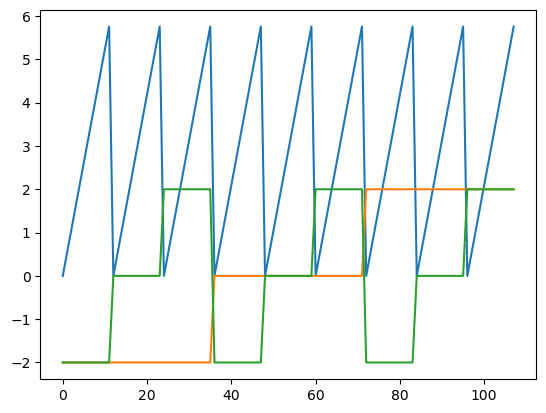

In [12]:
tt=2
arng=np.arange(0,360,30)

arng=np.deg2rad(arng)
arng=np.hstack([arng[:,None], np.zeros((len(arng),2))])

tid=np.indices((tt*2-1, tt*2-1)).reshape(2, -1).T-(tt-1)
tid=np.hstack([np.zeros((len(tid), 1)), tid])
tid*=2
print(arng.shape, tid.shape)
arng=arng[None,:,:]+tid[:,None,:]
arng=arng.reshape((-1,3))
print(arng.shape)
plt.plot(arng[:,0])
plt.plot(arng[:,1])
plt.plot(arng[:,2])

In [13]:
def rotate_image_arng(img):
    return rotate_translate_image(img, arng)
    
def rotate_image_arng_mult(imgs):
    return jax.vmap(rotate_image_arng)(imgs)

(1, 108, 64, 64)


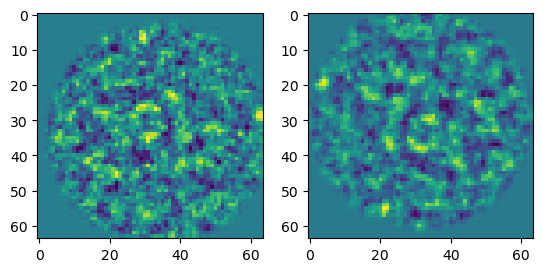

In [14]:
p=jax.vmap(rotate_image_arng)(projs[3:4])
print(p.shape)
plt.subplot(1,2,1)
plt.imshow(p[0,0])
plt.subplot(1,2,2)
plt.imshow(p[0,5])

In [15]:
@jit
def calc_loss(variables, batch, rng_drop):
    enc_var, dec_var=variables    
    # pjrot=rotate_image_arng_mult(batch)
    
    mid = encode_model.apply(enc_var, batch[:,:,:,None], training=True, rngs={"dropout": rng_drop})    
    output = decode_model.apply(dec_var, mid, training=True, rngs={"dropout": rng_drop})

    outrot=rotate_image_arng_mult(output[...,0])
    
    diff=batch[:,None,:,:]-outrot
    diff=jnp.mean(diff**2, axis=(2,3))
    
    loss=jnp.min(diff, axis=1)
    loss=jnp.mean(loss)

    # loss+=abs(jnp.std(output)-0.1)*0.01
    
    return loss

variables=[enc_var, dec_var]
batch = projs[:2]
loss=calc_loss(variables, batch, rng_drop)
grad_fn=jax.value_and_grad(calc_loss)
loss, grads=grad_fn(variables, batch, rng_drop)
print(loss)


2024-10-14 14:29:03.548487: E external/xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 1s:

  %subtract.923 = f32[108,4096,2]{2,1,0} subtract(f32[108,4096,2]{2,1,0} %broadcast.40, f32[108,4096,2]{1,2,0} %constant.229), metadata={op_name="jit(calc_loss)/jit(main)/sub" source_file="/tmp/ipykernel_240261/3892362693.py" source_line=22}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2024-10-14 14:29:03.570811: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.022435354s
Constant folding an instruction is taking > 1s:

  %subtract.923 = f32[108,4096,2]{2,1,0} subtract(f32[108,40

0.9927844


In [16]:

variables=[enc_var, dec_var]

optimizer = optax.adam(1e-4)
opt_state = optimizer.init(variables)
cost=[]

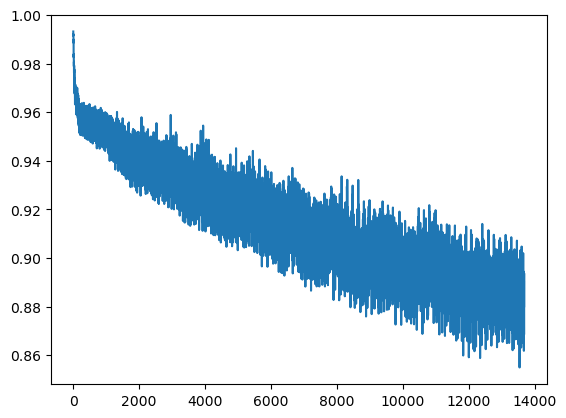

In [27]:
bsz=32
for itr in range(40):
    for ib in range(0,len(projs),bsz):
        batch=projs[ib:ib+bsz]
        
        loss, grads=grad_fn(variables, batch, rng_drop)
        
        rng_drop=jax.random.fold_in(rng_drop,123)
        
        updates, opt_state = optimizer.update(grads, opt_state)
        variables = optax.apply_updates(variables, updates)
        if (ib//bsz)%4==0:
            print(itr, ib//bsz, len(projs)//bsz, loss, end='\r')
        cost.append(loss)

plt.plot(cost)

(4, 64, 64, 1) 0.37251508


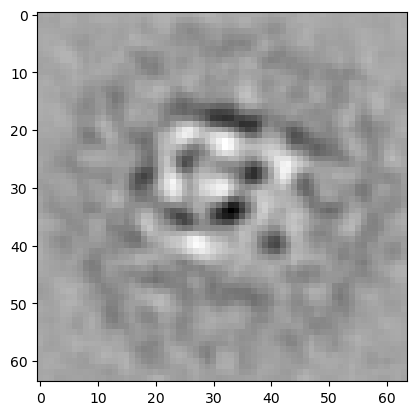

In [28]:
enc_var, dec_var=variables
batch=projs[:4]
mid = encode_model.apply(enc_var, batch[:,:,:,None])
output = decode_model.apply(dec_var, mid)
print(output.shape, np.std(output))
o=output[0,:,:,0]
plt.imshow(o, cmap='gray')


In [29]:
midall=[]
for ib in range(0,len(projs),bsz):
    batch=projs[ib:ib+bsz]
    mid = encode_model.apply(enc_var, batch[:,:,:,None])
    midall.append(mid)

mid=np.concatenate(midall)
print(mid.shape)

(5464, 8)


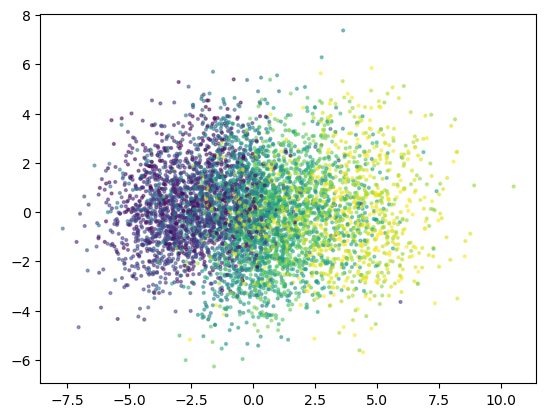

In [30]:
pca=PCA(2)
m=pca.fit_transform(mid)
plt.scatter(m[:,0], m[:,1],c=clsid, s=4, alpha=.5)

(8, 64, 64, 1)


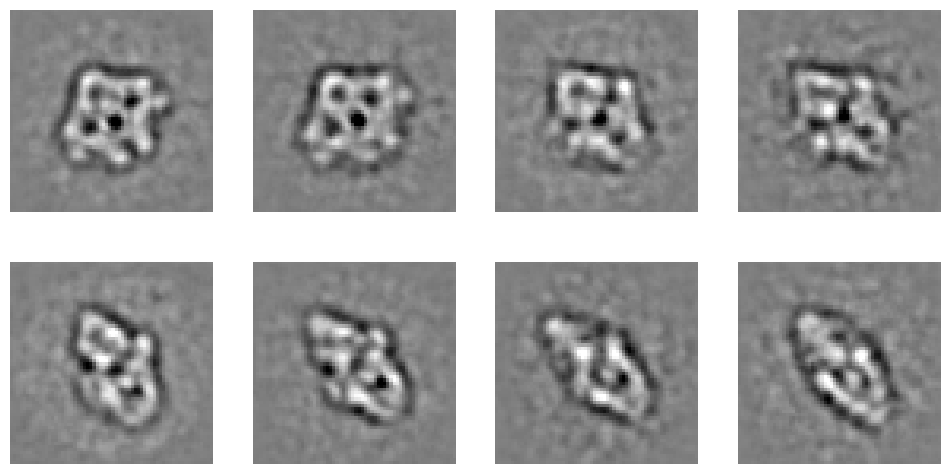

In [31]:
from sklearn.cluster import KMeans
nk=8
km=KMeans(nk ,max_iter=30)
km.fit(m)
mc=km.cluster_centers_
mc=mc[np.argsort(mc[:,0])]

mc=pca.inverse_transform(mc)

output = decode_model.apply(dec_var, mc)
print(output.shape)

plt.figure(figsize=(12,6))
for i in range(nk):
    o=output[i,:,:,0]
    plt.subplot(2,4,i+1)
    s=np.std(o)*5
    plt.imshow(o, vmin=-s, vmax=s, cmap='gray')
    plt.axis("off")

In [186]:
from flax.serialization import to_state_dict, from_state_dict
variables00 = to_state_dict(variables)
# print(variables00)
